## Setup

In [47]:
%matplotlib inline

In [48]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

In [49]:
from aif360.datasets import StandardDataset
StandardDataset??

In [50]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias 
from metrics_utils import get_orig_model_metrics

from sklearn import preprocessing

# Privacy Meter
from privacy_meter.dataset import Dataset

from aif360.datasets import BinaryLabelDataset

In [51]:
import os
import shutil
import glob

## Arguments & Initializations

In [52]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")
ap.add_argument("-a", "--attack", choices=['mia1', 'mia2'], default='mia1', help="attacks: our implementation, their implementation")

_StoreAction(option_strings=['-a', '--attack'], dest='attack', nargs=None, const=None, default='mia1', type=None, choices=['mia1', 'mia2'], required=False, help='attacks: our implementation, their implementation', metavar=None)

In [53]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [54]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2,
 'attack': 'mia1'}

In [55]:
DATASET = "law_sex"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])
ATTACK = "mia1"

In [56]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 20

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

eg_metrics = defaultdict(list) 
eg_mia_metrics = defaultdict(list) 


pr_orig_metrics = defaultdict(list) 
cpp_metrics = defaultdict(list) 
ro_metrics = defaultdict(list) 

In [57]:
ATTACK

'mia1'

## Loading & Splitting Dataset

In [58]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

In [59]:
dataset_orig.features.shape

(20798, 13)

In [60]:
privileged_groups

[{'gender': 1}]

In [61]:
sens_attr

'gender'

In [62]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

In [63]:
if ATTACK == "mia1":
    # training data split ratio
    p = 0.5
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print(dataset_orig_train.features)

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')
        
    dataset_orig_train
    dataset_orig_train?

[[10. 10.  0. ...  4.  6.  8.]
 [ 1.  2.  0. ...  5.  5.  5.]
 [ 2.  4.  0. ...  3.  6.  6.]
 ...
 [ 8.  8.  0. ...  2.  5.  5.]
 [ 4.  6.  0. ...  4.  6.  7.]
 [ 1.  1.  0. ...  3.  5.  5.]]
no bias type specified


## Run Mitigating Algorithms

### Setup for MIA2

In [64]:
seed = 1234
np.random.seed(seed)

In [65]:
if ATTACK == "mia2":
    # prepare data format
    X = dataset_orig.features
    y_true = dataset_orig.labels.ravel()
    sens_attr = dataset_orig.protected_attribute_names[0]
    sens_attr_index = dataset_orig.feature_names.index(sens_attr)
    sensitive_features = dataset_orig.features[:, sens_attr_index]

    X_other_features = np.delete(X, sens_attr_index, axis=1)
    X_other_features_normalized = preprocessing.normalize(X_other_features, norm='l2')

    # Reconstruct X by combining the sensitive attribute and the normalized features
    # Insert the sensitive attribute back into its original position
    X_normalized = np.insert(X_other_features_normalized, sens_attr_index, sensitive_features, axis=1)
    X = X_normalized

In [66]:
def get_unique_indices_reference():
    # Determine split sizes proportionally (to sum up to the full dataset size)
    num_train_points = int(X.shape[0] * 0.12)
    num_test_points = int(X.shape[0] * 0.12)
    num_population_points = int(X.shape[0] * 0.3)  # Reduced from 30000

    # Start with all indices
    all_indices = np.arange(X.shape[0])

    # Select train indices without replacement
    train_index = np.random.choice(all_indices, num_train_points, replace=False)
    # Remove train indices from available indices
    remaining_indices = np.setdiff1d(all_indices, train_index)

    # Select test indices from the remaining indices without replacement
    test_index = np.random.choice(remaining_indices, num_test_points, replace=False)
    # Remove test indices from available indices
    remaining_indices = np.setdiff1d(remaining_indices, test_index)

    # Select population indices from the remaining indices (can also choose all remaining points)
    population_index = np.random.choice(remaining_indices, min(num_population_points, len(remaining_indices)), replace=False)

    # Summary of counts
    print("==============================================================")
    print("GET UNIQUE INDICES REFERENCE")
    print(f"Number of train points: {len(train_index)}")
    print(f"Number of test points: {len(test_index)}")
    print(f"Number of population points: {len(population_index)}")
    print("==============================================================")
    
    return train_index, test_index, population_index

In [67]:
def create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train):
    # create the target model's dataset
    train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
    test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
    target_dataset = Dataset(
        data_dict={'train': train_ds, 'test': test_ds},
        default_input='x', default_output='y', default_group='g'
    )

    # create the reference dataset
    population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
    reference_dataset = Dataset(
        data_dict={'train': population_ds},
        default_input='x', default_output='y', default_group='g'
    )
    
    return target_dataset, reference_dataset

In [68]:
# Combine features, labels, and protected attributes into a DataFrame
def create_binary_label_dataset(dataset_orig, X, y, sensitive_features, sens_attr_name, privileged_value, unprivileged_value):
    print("=====================================================")
    print("CREATE BINARY LABEL DATASET")
    # Extract the feature names from the original dataset
    feature_names = dataset_orig.feature_names

    # Create a DataFrame with features, labels, and sensitive attribute
    df = pd.DataFrame(X, columns=feature_names)
    df[dataset_orig.label_names[0]] = y
#     df[sens_attr_name] = sensitive_features

    print(df.head())
    # print(dataset_orig.feature_names)
    # print(dataset_orig.features.shape)
    
    # df_orig, _ = dataset_orig.convert_to_dataframe()

    # # Display the first few rows
    # print("Original df's head:", df_orig.head())
    
    # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset_orig.labels, return_counts=True)

    # # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")

    # Create the BinaryLabelDataset
    dataset = BinaryLabelDataset(
        favorable_label=1.0,  # Adjust as per your dataset
        unfavorable_label=0.0,  # Adjust as per your dataset
        df=df,  # DataFrame containing features, labels, and protected attribute
        label_names=dataset_orig.label_names,  # Column name of labels in DataFrame
        protected_attribute_names=[sens_attr_name],  # Protected attribute column
        privileged_protected_attributes=[privileged_value],  # Privileged group values
        unprivileged_protected_attributes=[unprivileged_value]  # Unprivileged group values
    )
    
    # print(dataset.feature_names)
    # print(dataset.features.shape)
    # # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset.labels, return_counts=True)

    # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")
    
    print("=====================================================")
    
    return dataset

In [69]:
def delete_logs():
    # Search for directories ending with _group or _pop
    for pattern in ["*_group", "*_pop"]:
        # Find matching directories
        for log_dir in glob.glob(pattern):
            if os.path.exists(log_dir) and os.path.isdir(log_dir):  # Ensure it's a directory
                shutil.rmtree(log_dir)
                print(f"{log_dir} deleted.")

### Calling Both

In [70]:
target_dataset = None
reference_dataset = None

In [71]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

# run mitigating algorithms
for i in range(N):
    if ATTACK == "mia1":
        # split dataset into train, validation, and test
        dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
        dataset_orig_val = dataset_orig_test

        print("#### Train dataset's features are as below:")
        print(dataset_orig_train.features)
    elif ATTACK == "mia2":
        train_index, test_index, population_index = get_unique_indices_reference()
        
        g_train = y_true[train_index] + (sensitive_features[train_index] + 1) * 2 # 2, 4, 3, 5
        g_test = y_true[test_index] + (sensitive_features[test_index] + 1) * 2
        g_pop_train = y_true[population_index] + (sensitive_features[population_index] + 1) * 2
        
        # for Audit
        target_dataset, reference_dataset = create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train)
        
        # for mitigators
        privileged_value = [1]
        unprivileged_value = [0]
        # Convert train dataset
        dataset_orig_train = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[train_index],
            y=y_true[train_index],
            sensitive_features=sensitive_features[train_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        # Convert test dataset
        dataset_orig_val = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[test_index],
            y=y_true[test_index],
            sensitive_features=sensitive_features[test_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        # Since validation and testing datasets are the same
        dataset_orig_test = dataset_orig_val
        
        # orig_metrics, orig_mia_metrics, priv_metric_orig, favor_metric_orig = run_MIA2(dataset_orig, target_dataset, reference_dataset, privileged_groups, unprivileged_groups, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, SCALER)
        
    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig.favorable_label
    uf_label = dataset_orig.unfavorable_label
    feature_names = dataset_orig.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf 
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods 
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)
    
    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 
    
    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

    # eg mitigator, in-processing
    eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)
#     # egr gave error so I replaced it with reweigh
# #     eg_metrics, eg_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, eg_metrics, eg_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

#     # cpp mitigator
#     cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

#     # ro mitigator
#     # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

#     if (BASELINE == 'lr'):
#         pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

    delete_logs()

#### Train dataset's features are as below:
[[7. 7. 0. ... 4. 6. 8.]
 [7. 6. 0. ... 3. 6. 6.]
 [9. 8. 0. ... 3. 6. 8.]
 ...
 [6. 6. 0. ... 3. 6. 8.]
 [1. 1. 0. ... 4. 0. 0.]
 [1. 1. 0. ... 4. 6. 6.]]
no bias type specified
#### Training Dataset shape
(10399, 13)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['gender']
#### Privileged and unprivileged protected groups
[{'gender': 1}] [{'gender': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['decile3', 'decile1', 'race', 'cluster', 'lsat', 'ugpa', 'dob_yr', 'fulltime', 'fam_inc', 'gender', 'tier', 'indxgrp', 'indxgrp2']
privileged vs. unprivileged:  5849.0 4550.0
base_pos unpriv:  0.9415384615384615
base_pos priv:  0.9565737732945803
number of favorable labels:  9879
Difference in mean outcomes between unprivileged and privileged groups = -0.015035
#### Train shape, validation shape, test shape
(10399, 13) (10399, 13) (10399, 13)
####

RUN DIRMITIGATOR
[INFO]: training decision tree
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 266
Number of test samples (ntest): 249
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4284
Number of test samples (ntest): 4324
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 254
Number of test samples (ntest): 271
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5595
Number of test samples (ntest): 5555
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.88      0.42      0.57       520
         1.0       0.97      1.00      0.98      9879

    accuracy                           0.97     10399
   macro avg       0.92      0.71      0.77     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9679776901625157
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original 

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 266
Number of test samples (ntest): 249
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4284
Number of test samples (ntest): 4324
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 254
Number of test samples (ntest): 271
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5595
Number of test samples (ntest): 5555
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.67      0.24      0.36       520
         1.0       0.96      0.99      0.98      9879

    accuracy                           0.96     10399
   macro avg       0.81      0.62      0.67     10399
weighted avg       0.95      0.96      0.95     10399

Train accuracy:  0.9560534666794884
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.31
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -1.1914530789810085
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 520, Test = 520
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.27
  Test Accuracy (TNR): 0.84
  Attacker advantage: 0.11
  Positive predictive value: 0.63
  Optimal thershold: -1.1914530789810085
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9879, Test = 9879
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.01
  Attacker advantage: 0.00
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulation

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 4308
Number of test samples (ntest): 4300
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 262
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5580
Number of test samples (ntest): 5570
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.87      0.50      0.63       511
         1.0       0.97      1.00      0.99      9888

    accuracy                           0.97     10399
   macro avg       0.92      0.75      0.81     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.9714395614962977
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.43
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.55


Number of training samples (ntrain): 4308
Number of test samples (ntest): 4300
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 262
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5580
Number of test samples (ntest): 5570
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.90      0.44      0.59       511
         1.0       0.97      1.00      0.98      9888

    accuracy                           0.97     10399
   macro avg       0.94      0.72      0.79     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.970189441292432
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.48000000000000004
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accurac

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 248
Number of test samples (ntest): 267
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4308
Number of test samples (ntest): 4300
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 262
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5580
Number of test samples (ntest): 5570
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.66      0.29      0.40       511
         1.0       0.96      0.99      0.98      9888

    accuracy                           0.96     10399
   macro avg       0.81      0.64      0.69     10399
weighted avg       0.95      0.96      0.95     10399

Train accuracy:  0.9577844023463794
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.16
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 511, Test = 529
  AUC: 0.59
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.36
  Test Accuracy (TNR): 0.80
  Attacker advantage: 0.16
  Positive predictive value: 0.70
  Optimal thershold: -1.8550067293335164
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9888, Test = 9870
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulat

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 4279
Number of test samples (ntest): 4329
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 264
Number of test samples (ntest): 261
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5599
Number of test samples (ntest): 5551
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.89      0.44      0.59       521
         1.0       0.97      1.00      0.98      9878

    accuracy                           0.97     10399
   macro avg       0.93      0.72      0.79     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9693239734589865
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.65
 

Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -1.55814461804655
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 521, Test = 519
  AUC: 0.75
  Privacy Risk: 0.68
  Accuracy: 0.68
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.67
  Attacker advantage: 0.36
  Positive predictive value: 0.76
  Optimal thershold: -1.6739764335716716
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9878, Test = 9880
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.262364264467491
)
MIA_Result(
  Name: subpopulation_

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 257
Number of test samples (ntest): 258
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4279
Number of test samples (ntest): 4329
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 264
Number of test samples (ntest): 261
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5599
Number of test samples (ntest): 5551
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.64      0.21      0.32       521
         1.0       0.96      0.99      0.98      9878

    accuracy                           0.95     10399
   macro avg       0.80      0.60      0.65     10399
weighted avg       0.94      0.95      0.94     10399

Train accuracy:  0.9544186941052024
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.42000000000000004
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 521, Test = 519
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.30
  Test Accuracy (TNR): 0.80
  Attacker advantage: 0.10
  Positive predictive value: 0.63
  Optimal thershold: -0.8891468186974045
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9878, Test = 9880
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  N

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 4260
Number of test samples (ntest): 4348
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 268
Number of test samples (ntest): 257
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5637
Number of test samples (ntest): 5513
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.87      0.54      0.66       502
         1.0       0.98      1.00      0.99      9897

    accuracy                           0.97     10399
   macro avg       0.92      0.77      0.82     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.9737474757188191
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.81
 

Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -0.11778303565638351
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 502, Test = 538
  AUC: 0.77
  Privacy Risk: 0.71
  Accuracy: 0.70
  Train Accuracy (TPR): 0.80
  Test Accuracy (TNR): 0.61
  Attacker advantage: 0.41
  Positive predictive value: 0.75
  Optimal thershold: -2.2155737160044158
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9897, Test = 9861
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.11778303565638351
)
MIA_Result(
  Name: subpopula

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 234
Number of test samples (ntest): 281
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4260
Number of test samples (ntest): 4348
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 268
Number of test samples (ntest): 257
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5637
Number of test samples (ntest): 5513
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.62      0.26      0.37       502
         1.0       0.96      0.99      0.98      9897

    accuracy                           0.96     10399
   macro avg       0.79      0.63      0.67     10399
weighted avg       0.95      0.96      0.95     10399

Train accuracy:  0.9568227714203289
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.44
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -0.5772340014177539
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 502, Test = 538
  AUC: 0.57
  Privacy Risk: 0.57
  Accuracy: 0.58
  Train Accuracy (TPR): 0.36
  Test Accuracy (TNR): 0.78
  Attacker advantage: 0.14
  Positive predictive value: 0.61
  Optimal thershold: -2.48901681297574
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9897, Test = 9861
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulation_0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 4264
Number of test samples (ntest): 4344
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 254
Number of test samples (ntest): 271
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5625
Number of test samples (ntest): 5525
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.89      0.50      0.64       510
         1.0       0.97      1.00      0.99      9889

    accuracy                           0.97     10399
   macro avg       0.93      0.75      0.81     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.9724011924223483
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.68
 

Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR): 0.38
  Attacker advantage: 0.05
  Positive predictive value: 0.53
  Optimal thershold: -0.00548322141453137
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 510, Test = 530
  AUC: 0.76
  Privacy Risk: 0.70
  Accuracy: 0.70
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.73
  Attacker advantage: 0.40
  Positive predictive value: 0.75
  Optimal thershold: -1.5040773967762742
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9889, Test = 9869
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.35
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: -0.00548322141453137
)
MIA_Result(
  Name: subpopula

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 256
Number of test samples (ntest): 259
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4264
Number of test samples (ntest): 4344
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 254
Number of test samples (ntest): 271
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5625
Number of test samples (ntest): 5525
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.61      0.27      0.38       510
         1.0       0.96      0.99      0.98      9889

    accuracy                           0.96     10399
   macro avg       0.79      0.63      0.68     10399
weighted avg       0.95      0.96      0.95     10399

Train accuracy:  0.9558611404942783
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.19
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 510, Test = 530
  AUC: 0.59
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.38
  Test Accuracy (TNR): 0.77
  Attacker advantage: 0.15
  Positive predictive value: 0.74
  Optimal thershold: -1.7077741529709956
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9889, Test = 9869
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.03
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulat

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 4272
Number of test samples (ntest): 4336
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 251
Number of test samples (ntest): 274
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5627
Number of test samples (ntest): 5523
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.84      0.42      0.56       500
         1.0       0.97      1.00      0.98      9899

    accuracy                           0.97     10399
   macro avg       0.91      0.71      0.77     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9684585056255409
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.97
 

Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.8472978603872036
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 500, Test = 540
  AUC: 0.72
  Privacy Risk: 0.67
  Accuracy: 0.67
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.65
  Attacker advantage: 0.34
  Positive predictive value: 0.70
  Optimal thershold: -2.0476928433652555
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9899, Test = 9859
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.1941560144409575
)
MIA_Result(
  Name: subpopulati

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 249
Number of test samples (ntest): 266
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4272
Number of test samples (ntest): 4336
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 251
Number of test samples (ntest): 274
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5627
Number of test samples (ntest): 5523
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.68      0.20      0.31       500
         1.0       0.96      1.00      0.98      9899

    accuracy                           0.96     10399
   macro avg       0.82      0.60      0.64     10399
weighted avg       0.95      0.96      0.95     10399

Train accuracy:  0.956918934512934
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.05
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 500, Test = 540
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.56
  Train Accuracy (TPR): 0.30
  Test Accuracy (TNR): 0.81
  Attacker advantage: 0.10
  Positive predictive value: 0.59
  Optimal thershold: -3.0195268399757658
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9899, Test = 9859
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulat

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 4277
Number of test samples (ntest): 4331
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 252
Number of test samples (ntest): 273
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5607
Number of test samples (ntest): 5543
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.88      0.46      0.60       515
         1.0       0.97      1.00      0.98      9884

    accuracy                           0.97     10399
   macro avg       0.92      0.73      0.79     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.9699971151072219
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.87
 

Number of training samples (ntrain): 4277
Number of test samples (ntest): 4331
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 252
Number of test samples (ntest): 273
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5607
Number of test samples (ntest): 5543
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.93      0.43      0.59       515
         1.0       0.97      1.00      0.98      9884

    accuracy                           0.97     10399
   macro avg       0.95      0.72      0.79     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.970285604385037
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.49
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.86
 

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 252
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4277
Number of test samples (ntest): 4331
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 252
Number of test samples (ntest): 273
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5607
Number of test samples (ntest): 5543
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.66      0.28      0.39       515
         1.0       0.96      0.99      0.98      9884

    accuracy                           0.96     10399
   macro avg       0.81      0.64      0.69     10399
weighted avg       0.95      0.96      0.95     10399

Train accuracy:  0.9572074237907491
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.47000000000000003
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 515, Test = 525
  AUC: 0.58
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.38
  Test Accuracy (TNR): 0.77
  Attacker advantage: 0.15
  Positive predictive value: 0.65
  Optimal thershold: -0.7666362073392801
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9884, Test = 9874
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  N

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 4303
Number of test samples (ntest): 4305
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 275
Number of test samples (ntest): 250
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5551
Number of test samples (ntest): 5599
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.85      0.40      0.55       545
         1.0       0.97      1.00      0.98      9854

    accuracy                           0.96     10399
   macro avg       0.91      0.70      0.76     10399
weighted avg       0.96      0.96      0.96     10399

Train accuracy:  0.9649966342917589
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.45
 

Best thresh:  0.4
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.03
  Positive predictive value: 0.53
  Optimal thershold: -0.35667494393873245
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 545, Test = 495
  AUC: 0.71
  Privacy Risk: 0.65
  Accuracy: 0.66
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.56
  Attacker advantage: 0.31
  Positive predictive value: 0.78
  Optimal thershold: -2.1000608288825715
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9854, Test = 9904
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.3364722366212129
)
MIA_Result(
  Name: subpopulat

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 270
Number of test samples (ntest): 245
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4303
Number of test samples (ntest): 4305
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 275
Number of test samples (ntest): 250
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5551
Number of test samples (ntest): 5599
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.67      0.27      0.39       545
         1.0       0.96      0.99      0.98      9854

    accuracy                           0.95     10399
   macro avg       0.82      0.63      0.68     10399
weighted avg       0.95      0.95      0.95     10399

Train accuracy:  0.9549956726608327
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.4
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.9310062923557597
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 545, Test = 495
  AUC: 0.56
  Privacy Risk: 0.56
  Accuracy: 0.55
  Train Accuracy (TPR): 0.30
  Test Accuracy (TNR): 0.83
  Attacker advantage: 0.13
  Positive predictive value: 0.66
  Optimal thershold: -0.895492393038264
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9854, Test = 9904
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.01
  Attacker advantage: 0.00
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulation_0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 4299
Number of test samples (ntest): 4309
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 254
Number of test samples (ntest): 271
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5577
Number of test samples (ntest): 5573
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.91      0.45      0.60       523
         1.0       0.97      1.00      0.98      9876

    accuracy                           0.97     10399
   macro avg       0.94      0.72      0.79     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.970189441292432
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.98
  

Number of training samples (ntrain): 4299
Number of test samples (ntest): 4309
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 254
Number of test samples (ntest): 271
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5577
Number of test samples (ntest): 5573
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.85      0.46      0.60       523
         1.0       0.97      1.00      0.98      9876

    accuracy                           0.97     10399
   macro avg       0.91      0.73      0.79     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9688431579959611
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.47000000000000003
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accura

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 269
Number of test samples (ntest): 246
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4299
Number of test samples (ntest): 4309
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 254
Number of test samples (ntest): 271
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5577
Number of test samples (ntest): 5573
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.64      0.25      0.36       523
         1.0       0.96      0.99      0.98      9876

    accuracy                           0.95     10399
   macro avg       0.80      0.62      0.67     10399
weighted avg       0.94      0.95      0.95     10399

Train accuracy:  0.9549956726608327
Validating EG ...
TEST


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


POS IND 1
NEG IND 0
Best thresh:  0.46
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 523, Test = 517
  AUC: 0.59
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.41
  Test Accuracy (TNR): 0.78
  Attacker advantage: 0.18
  Positive predictive value: 0.73
  Optimal thershold: -1.8142336996055124
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9876, Test = 9882
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 4232
Number of test samples (ntest): 4376
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 261
Number of test samples (ntest): 264
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5633
Number of test samples (ntest): 5517
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.86      0.46      0.60       534
         1.0       0.97      1.00      0.98      9865

    accuracy                           0.97     10399
   macro avg       0.92      0.73      0.79     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9686508318107511
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.44
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.80


Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.80
  Test Accuracy (TNR): 0.23
  Attacker advantage: 0.03
  Positive predictive value: 0.52
  Optimal thershold: -0.0472528848505455
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 534, Test = 506
  AUC: 0.74
  Privacy Risk: 0.67
  Accuracy: 0.68
  Train Accuracy (TPR): 0.81
  Test Accuracy (TNR): 0.54
  Attacker advantage: 0.35
  Positive predictive value: 0.74
  Optimal thershold: -2.313056392861341
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9865, Test = 9893
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.20
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.0472528848505455
)
MIA_Result(
  Name: subpopulatio

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 273
Number of test samples (ntest): 242
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4232
Number of test samples (ntest): 4376
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 261
Number of test samples (ntest): 264
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5633
Number of test samples (ntest): 5517
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.65      0.24      0.35       534
         1.0       0.96      0.99      0.98      9865

    accuracy                           0.95     10399
   macro avg       0.80      0.62      0.66     10399
weighted avg       0.94      0.95      0.94     10399

Train accuracy:  0.9543225310125973
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.11
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -2.284558959367497
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 534, Test = 506
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.54
  Train Accuracy (TPR): 0.30
  Test Accuracy (TNR): 0.80
  Attacker advantage: 0.09
  Positive predictive value: 0.64
  Optimal thershold: -2.284558959367497
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9865, Test = 9893
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulation_0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 4321
Number of test samples (ntest): 4287
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 252
Number of test samples (ntest): 273
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5575
Number of test samples (ntest): 5575
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.87      0.40      0.55       503
         1.0       0.97      1.00      0.98      9896

    accuracy                           0.97     10399
   macro avg       0.92      0.70      0.76     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9680738532551206
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.95
 

Number of training samples (ntrain): 4321
Number of test samples (ntest): 4287
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 252
Number of test samples (ntest): 273
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5575
Number of test samples (ntest): 5575
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.84      0.40      0.54       503
         1.0       0.97      1.00      0.98      9896

    accuracy                           0.97     10399
   macro avg       0.90      0.70      0.76     10399
weighted avg       0.96      0.97      0.96     10399

Train accuracy:  0.9674007116068852
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.48000000000000004
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accura

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 251
Number of test samples (ntest): 264
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4321
Number of test samples (ntest): 4287
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 252
Number of test samples (ntest): 273
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5575
Number of test samples (ntest): 5575
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.69      0.19      0.30       503
         1.0       0.96      1.00      0.98      9896

    accuracy                           0.96     10399
   macro avg       0.82      0.59      0.64     10399
weighted avg       0.95      0.96      0.94     10399

Train accuracy:  0.9566304452351188
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.04
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 503, Test = 537
  AUC: 0.57
  Privacy Risk: 0.56
  Accuracy: 0.57
  Train Accuracy (TPR): 0.34
  Test Accuracy (TNR): 0.78
  Attacker advantage: 0.12
  Positive predictive value: 0.69
  Optimal thershold: -3.2542658315381208
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9896, Test = 9862
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulat

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 4267
Number of test samples (ntest): 4341
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 281
Number of test samples (ntest): 244
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5588
Number of test samples (ntest): 5562
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.89      0.45      0.59       544
         1.0       0.97      1.00      0.98      9855

    accuracy                           0.97     10399
   macro avg       0.93      0.72      0.79     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9681700163477257
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.96
 

Number of training samples (ntrain): 4267
Number of test samples (ntest): 4341
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 281
Number of test samples (ntest): 244
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5588
Number of test samples (ntest): 5562
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.90      0.38      0.53       544
         1.0       0.97      1.00      0.98      9855

    accuracy                           0.97     10399
   macro avg       0.93      0.69      0.76     10399
weighted avg       0.96      0.97      0.96     10399

Train accuracy:  0.965285123569574
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.48000000000000004
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accurac

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 252
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4267
Number of test samples (ntest): 4341
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 281
Number of test samples (ntest): 244
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5588
Number of test samples (ntest): 5562
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.65      0.27      0.38       544
         1.0       0.96      0.99      0.98      9855

    accuracy                           0.95     10399
   macro avg       0.81      0.63      0.68     10399
weighted avg       0.94      0.95      0.95     10399

Train accuracy:  0.9542263679199923
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.09
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 544, Test = 496
  AUC: 0.57
  Privacy Risk: 0.58
  Accuracy: 0.57
  Train Accuracy (TPR): 0.37
  Test Accuracy (TNR): 0.78
  Attacker advantage: 0.15
  Positive predictive value: 0.67
  Optimal thershold: -2.41661496428219
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9855, Test = 9903
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulatio

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 4311
Number of test samples (ntest): 4297
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 288
Number of test samples (ntest): 237
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5554
Number of test samples (ntest): 5596
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.92      0.42      0.57       534
         1.0       0.97      1.00      0.98      9865

    accuracy                           0.97     10399
   macro avg       0.95      0.71      0.78     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9681700163477257
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
 

Number of training samples (ntrain): 4311
Number of test samples (ntest): 4297
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 288
Number of test samples (ntest): 237
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5554
Number of test samples (ntest): 5596
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.93      0.41      0.57       534
         1.0       0.97      1.00      0.98      9865

    accuracy                           0.97     10399
   macro avg       0.95      0.70      0.77     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9679776901625157
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.49
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 246
Number of test samples (ntest): 269
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4311
Number of test samples (ntest): 4297
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 288
Number of test samples (ntest): 237
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5554
Number of test samples (ntest): 5596
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.68      0.25      0.37       534
         1.0       0.96      0.99      0.98      9865

    accuracy                           0.96     10399
   macro avg       0.82      0.62      0.67     10399
weighted avg       0.95      0.96      0.95     10399

Train accuracy:  0.955380325031253
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.35000000000000003
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 534, Test = 506
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.35
  Test Accuracy (TNR): 0.76
  Attacker advantage: 0.11
  Positive predictive value: 0.75
  Optimal thershold: -1.0608278440113583
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9865, Test = 9893
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  N

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 4369
Number of test samples (ntest): 4239
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 252
Number of test samples (ntest): 273
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5538
Number of test samples (ntest): 5612
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.93      0.44      0.60       492
         1.0       0.97      1.00      0.99      9907

    accuracy                           0.97     10399
   macro avg       0.95      0.72      0.79     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.9720165400519281
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.98
 

Number of training samples (ntrain): 4369
Number of test samples (ntest): 4239
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 252
Number of test samples (ntest): 273
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5538
Number of test samples (ntest): 5612
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.42      0.59       492
         1.0       0.97      1.00      0.99      9907

    accuracy                           0.97     10399
   macro avg       0.96      0.71      0.79     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.9718242138667179
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.48000000000000004
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accura

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 240
Number of test samples (ntest): 275
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4369
Number of test samples (ntest): 4239
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 252
Number of test samples (ntest): 273
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5538
Number of test samples (ntest): 5612
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.63      0.23      0.34       492
         1.0       0.96      0.99      0.98      9907

    accuracy                           0.96     10399
   macro avg       0.80      0.61      0.66     10399
weighted avg       0.95      0.96      0.95     10399

Train accuracy:  0.9572074237907491
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.35000000000000003
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 492, Test = 548
  AUC: 0.57
  Privacy Risk: 0.57
  Accuracy: 0.58
  Train Accuracy (TPR): 0.34
  Test Accuracy (TNR): 0.80
  Attacker advantage: 0.14
  Positive predictive value: 0.61
  Optimal thershold: -1.0586155887382072
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9907, Test = 9851
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  N

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 4319
Number of test samples (ntest): 4289
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 274
Number of test samples (ntest): 251
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5539
Number of test samples (ntest): 5611
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.85      0.45      0.59       541
         1.0       0.97      1.00      0.98      9858

    accuracy                           0.97     10399
   macro avg       0.91      0.72      0.79     10399
weighted avg       0.96      0.97      0.96     10399

Train accuracy:  0.9672083854216752
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.92
 

Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: -0.2682639865946794
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 541, Test = 499
  AUC: 0.74
  Privacy Risk: 0.68
  Accuracy: 0.68
  Train Accuracy (TPR): 0.63
  Test Accuracy (TNR): 0.74
  Attacker advantage: 0.37
  Positive predictive value: 0.76
  Optimal thershold: -1.6094379124341005
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9858, Test = 9900
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.03
  Positive predictive value: 0.52
  Optimal thershold: -0.2682639865946794
)
MIA_Result(
  Name: subpopulati

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 267
Number of test samples (ntest): 248
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4319
Number of test samples (ntest): 4289
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 274
Number of test samples (ntest): 251
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5539
Number of test samples (ntest): 5611
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.65      0.25      0.36       541
         1.0       0.96      0.99      0.98      9858

    accuracy                           0.95     10399
   macro avg       0.81      0.62      0.67     10399
weighted avg       0.94      0.95      0.94     10399

Train accuracy:  0.9539378786421772
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.08
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 541, Test = 499
  AUC: 0.60
  Privacy Risk: 0.59
  Accuracy: 0.58
  Train Accuracy (TPR): 0.43
  Test Accuracy (TNR): 0.74
  Attacker advantage: 0.17
  Positive predictive value: 0.75
  Optimal thershold: -4.775062223377788
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9858, Test = 9900
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.03
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulati

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 4351
Number of test samples (ntest): 4257
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 261
Number of test samples (ntest): 264
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5560
Number of test samples (ntest): 5590
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.43      0.59       488
         1.0       0.97      1.00      0.99      9911

    accuracy                           0.97     10399
   macro avg       0.96      0.71      0.79     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.9722088662371382
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.98
 

Number of training samples (ntrain): 4351
Number of test samples (ntest): 4257
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 261
Number of test samples (ntest): 264
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5560
Number of test samples (ntest): 5590
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.93      0.44      0.60       488
         1.0       0.97      1.00      0.99      9911

    accuracy                           0.97     10399
   macro avg       0.95      0.72      0.79     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.9721127031445331
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.98
 

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 227
Number of test samples (ntest): 288
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4351
Number of test samples (ntest): 4257
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 261
Number of test samples (ntest): 264
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5560
Number of test samples (ntest): 5590
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.65      0.24      0.35       488
         1.0       0.96      0.99      0.98      9911

    accuracy                           0.96     10399
   macro avg       0.81      0.61      0.66     10399
weighted avg       0.95      0.96      0.95     10399

Train accuracy:  0.9581690547167997
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.08
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -0.07437875116913084
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 488, Test = 552
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.57
  Train Accuracy (TPR): 0.32
  Test Accuracy (TNR): 0.79
  Attacker advantage: 0.10
  Positive predictive value: 0.61
  Optimal thershold: -2.6355438584350983
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9911, Test = 9847
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulatio

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 4272
Number of test samples (ntest): 4336
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 252
Number of test samples (ntest): 273
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5612
Number of test samples (ntest): 5538
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.88      0.49      0.63       515
         1.0       0.97      1.00      0.99      9884

    accuracy                           0.97     10399
   macro avg       0.92      0.74      0.81     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.9712472353110876
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.58
 

Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.58
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: -0.0023228814161396385
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 515, Test = 525
  AUC: 0.73
  Privacy Risk: 0.68
  Accuracy: 0.68
  Train Accuracy (TPR): 0.76
  Test Accuracy (TNR): 0.59
  Attacker advantage: 0.35
  Positive predictive value: 0.73
  Optimal thershold: -2.159484249353372
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9884, Test = 9874
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.59
  Test Accuracy (TNR): 0.43
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.0023228814161396385
)
MIA_Result(
  Name: subpop

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 252
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4272
Number of test samples (ntest): 4336
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 252
Number of test samples (ntest): 273
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5612
Number of test samples (ntest): 5538
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.65      0.26      0.37       515
         1.0       0.96      0.99      0.98      9884

    accuracy                           0.96     10399
   macro avg       0.81      0.63      0.67     10399
weighted avg       0.95      0.96      0.95     10399

Train accuracy:  0.9564381190499086
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.12
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 515, Test = 525
  AUC: 0.58
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.39
  Test Accuracy (TNR): 0.76
  Attacker advantage: 0.15
  Positive predictive value: 0.62
  Optimal thershold: -2.199243142193768
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9884, Test = 9874
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.03
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulati

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 4312
Number of test samples (ntest): 4296
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 251
Number of test samples (ntest): 274
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5574
Number of test samples (ntest): 5576
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.88      0.47      0.61       513
         1.0       0.97      1.00      0.98      9886

    accuracy                           0.97     10399
   macro avg       0.93      0.73      0.80     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.9705740936628522
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.99
 

Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.04
  Positive predictive value: 0.53
  Optimal thershold: -0.15822400521489416
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 513, Test = 527
  AUC: 0.75
  Privacy Risk: 0.69
  Accuracy: 0.69
  Train Accuracy (TPR): 0.62
  Test Accuracy (TNR): 0.75
  Attacker advantage: 0.38
  Positive predictive value: 0.74
  Optimal thershold: -1.5404450409471488
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9886, Test = 9872
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.15822400521489416
)
MIA_Result(
  Name: subpopula

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 262
Number of test samples (ntest): 253
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4312
Number of test samples (ntest): 4296
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 251
Number of test samples (ntest): 274
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5574
Number of test samples (ntest): 5576
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.65      0.26      0.37       513
         1.0       0.96      0.99      0.98      9886

    accuracy                           0.96     10399
   macro avg       0.81      0.63      0.67     10399
weighted avg       0.95      0.96      0.95     10399

Train accuracy:  0.9566304452351188
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.04
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 513, Test = 527
  AUC: 0.58
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.37
  Test Accuracy (TNR): 0.79
  Attacker advantage: 0.16
  Positive predictive value: 0.64
  Optimal thershold: -3.3021597085691234
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9886, Test = 9872
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulat

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 4296
Number of test samples (ntest): 4312
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 247
Number of test samples (ntest): 278
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5599
Number of test samples (ntest): 5551
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.87      0.36      0.51       504
         1.0       0.97      1.00      0.98      9895

    accuracy                           0.97     10399
   macro avg       0.92      0.68      0.75     10399
weighted avg       0.96      0.97      0.96     10399

Train accuracy:  0.9664390806808347
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
 

Number of training samples (ntrain): 4296
Number of test samples (ntest): 4312
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 247
Number of test samples (ntest): 278
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5599
Number of test samples (ntest): 5551
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.83      0.51      0.63       504
         1.0       0.98      0.99      0.98      9895

    accuracy                           0.97     10399
   macro avg       0.90      0.75      0.81     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.9711510722184825
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.98
 

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 257
Number of test samples (ntest): 258
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4296
Number of test samples (ntest): 4312
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 247
Number of test samples (ntest): 278
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5599
Number of test samples (ntest): 5551
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.65      0.26      0.37       504
         1.0       0.96      0.99      0.98      9895

    accuracy                           0.96     10399
   macro avg       0.81      0.63      0.68     10399
weighted avg       0.95      0.96      0.95     10399

Train accuracy:  0.9573997499759592
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.19
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -0.19949738584817195
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 504, Test = 536
  AUC: 0.59
  Privacy Risk: 0.58
  Accuracy: 0.59
  Train Accuracy (TPR): 0.39
  Test Accuracy (TNR): 0.77
  Attacker advantage: 0.17
  Positive predictive value: 0.72
  Optimal thershold: -1.7100450885348624
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9895, Test = 9863
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulatio

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 4327
Number of test samples (ntest): 4281
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 258
Number of test samples (ntest): 267
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5558
Number of test samples (ntest): 5592
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.92      0.42      0.57       514
         1.0       0.97      1.00      0.98      9885

    accuracy                           0.97     10399
   macro avg       0.94      0.71      0.78     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9694201365515915
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.45
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.60


Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.64
  Test Accuracy (TNR): 0.40
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.0019550348358033506
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 514, Test = 526
  AUC: 0.71
  Privacy Risk: 0.66
  Accuracy: 0.66
  Train Accuracy (TPR): 0.55
  Test Accuracy (TNR): 0.77
  Attacker advantage: 0.32
  Positive predictive value: 0.72
  Optimal thershold: -1.3862943611198906
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9885, Test = 9873
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0.37
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.0019550348358033506
)
MIA_Result(
  Name: subpo

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 256
Number of test samples (ntest): 259
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4327
Number of test samples (ntest): 4281
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 258
Number of test samples (ntest): 267
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5558
Number of test samples (ntest): 5592
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.63      0.24      0.34       514
         1.0       0.96      0.99      0.98      9885

    accuracy                           0.96     10399
   macro avg       0.80      0.61      0.66     10399
weighted avg       0.95      0.96      0.95     10399

Train accuracy:  0.955380325031253
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.38
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 514, Test = 526
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.31
  Test Accuracy (TNR): 0.78
  Attacker advantage: 0.09
  Positive predictive value: 0.64
  Optimal thershold: -0.9770405448111287
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9885, Test = 9873
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulat

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [72]:
import pandas as pd
df_bank, _ = dataset_orig.convert_to_dataframe()

In [73]:
df_bank['gender'].value_counts()

gender
1.0    11675
0.0     9123
Name: count, dtype: int64

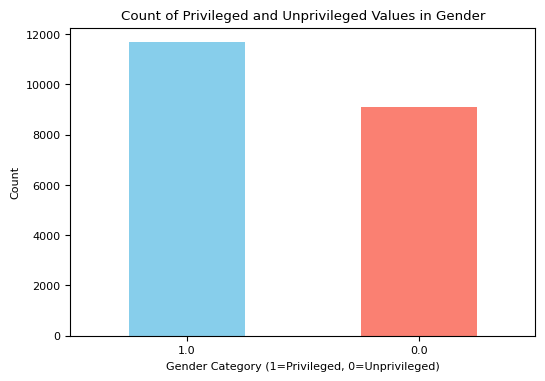

In [74]:
# Count the occurrences of privileged and unprivileged values
gender_counts = df_bank['gender'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
gender_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Privileged and Unprivileged Values in Gender')
plt.xlabel('Gender Category (1=Privileged, 0=Unprivileged)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [75]:
y_counts = df_bank['y'].value_counts()

KeyError: 'y'

In [76]:
# Count the occurrences of privileged and unprivileged values
label_counts = df_bank['y'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
age_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Favorable and Unfavorable Values in Dataset')
plt.xlabel('Label Category (1=Favorable, 0=Unfavorable)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

KeyError: 'y'

In [77]:
df_bank.shape

(20798, 14)

## Display Output

In [78]:
priv_metric_orig_copy = priv_metric_orig

In [79]:

priv_metric_orig_copy

defaultdict(float, {'total_priv': 116940.0, 'total_unpriv': 91040.0})

In [80]:
priv_metric_orig

defaultdict(float, {'total_priv': 116940.0, 'total_unpriv': 91040.0})

In [81]:
priv_metric_orig.items()

dict_items([('total_priv', 116940.0), ('total_unpriv', 91040.0)])

In [82]:
priv_metric_orig = priv_metric_orig_copy

In [83]:
orig_metrics.items()

dict_items([('bal_acc', [0.5680153900659518, 0.5707831296456966, 0.5620316631953383, 0.5801425125225769, 0.5791160428022185, 0.5911509694094135, 0.5694263915815465, 0.576720455769325, 0.565304245806513, 0.5774043131067641, 0.5705936523653985, 0.5673210586234865, 0.5838891155122659, 0.5591930160856617, 0.5649987854496873, 0.5729322584823157, 0.5755262980217406, 0.5750702925338066, 0.5427689571003342, 0.5593369442104845]), ('avg_odds_diff', [-0.053274765355204534, -0.027219965846037475, -0.01951156592459652, -0.009323049301025566, -0.015331583151922012, -0.04772011020679179, -0.054462608210930574, -0.044385981603946745, 0.0031988116115466703, -0.04992162474556361, -0.00841387356128448, -0.030119256071480582, -0.03138134106717838, -0.007808109204434643, -0.040198907175456766, 0.016844484649717162, -0.029449927876464943, -0.03145707117218871, -0.011942466548584496, -0.018496646637523262]), ('disp_imp', [0.011214250658833413, 0.008948926625609754, 0.005921560994568864, 0.005124118101926811,

In [84]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

1)

law_sex
10399
2)

              total_priv  total_unpriv
num_instance                          
orig              5847.0        4552.0
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.950337       0.049663     0.95543       0.04457      0.943790   
transf      0.955428       0.044572     0.95543       0.04457      0.955426   

         unpriv_unfavor  
dataset                  
orig           0.056210  
transf         0.044574  


In [85]:
orig_metrics.items()

dict_items([('bal_acc', [0.5680153900659518, 0.5707831296456966, 0.5620316631953383, 0.5801425125225769, 0.5791160428022185, 0.5911509694094135, 0.5694263915815465, 0.576720455769325, 0.565304245806513, 0.5774043131067641, 0.5705936523653985, 0.5673210586234865, 0.5838891155122659, 0.5591930160856617, 0.5649987854496873, 0.5729322584823157, 0.5755262980217406, 0.5750702925338066, 0.5427689571003342, 0.5593369442104845]), ('avg_odds_diff', [-0.053274765355204534, -0.027219965846037475, -0.01951156592459652, -0.009323049301025566, -0.015331583151922012, -0.04772011020679179, -0.054462608210930574, -0.044385981603946745, 0.0031988116115466703, -0.04992162474556361, -0.00841387356128448, -0.030119256071480582, -0.03138134106717838, -0.007808109204434643, -0.040198907175456766, 0.016844484649717162, -0.029449927876464943, -0.03145707117218871, -0.011942466548584496, -0.018496646637523262]), ('disp_imp', [0.011214250658833413, 0.008948926625609754, 0.005921560994568864, 0.005124118101926811,

In [86]:
print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
eg_error_metrics = {k: [statistics.stdev(v)] for (k,v) in eg_metrics.items()}
# pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
# cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
# ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
eg_metrics_mean = {k:[sum(v)/N] for (k,v) in eg_metrics.items()}
# pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
# cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
# ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

# if BASELINE == 'lr':
#     plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print("5)")
#     print(stat)
# else:
#     plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print(stat)

# plt.show()

4)



# Visualization

### Fairness

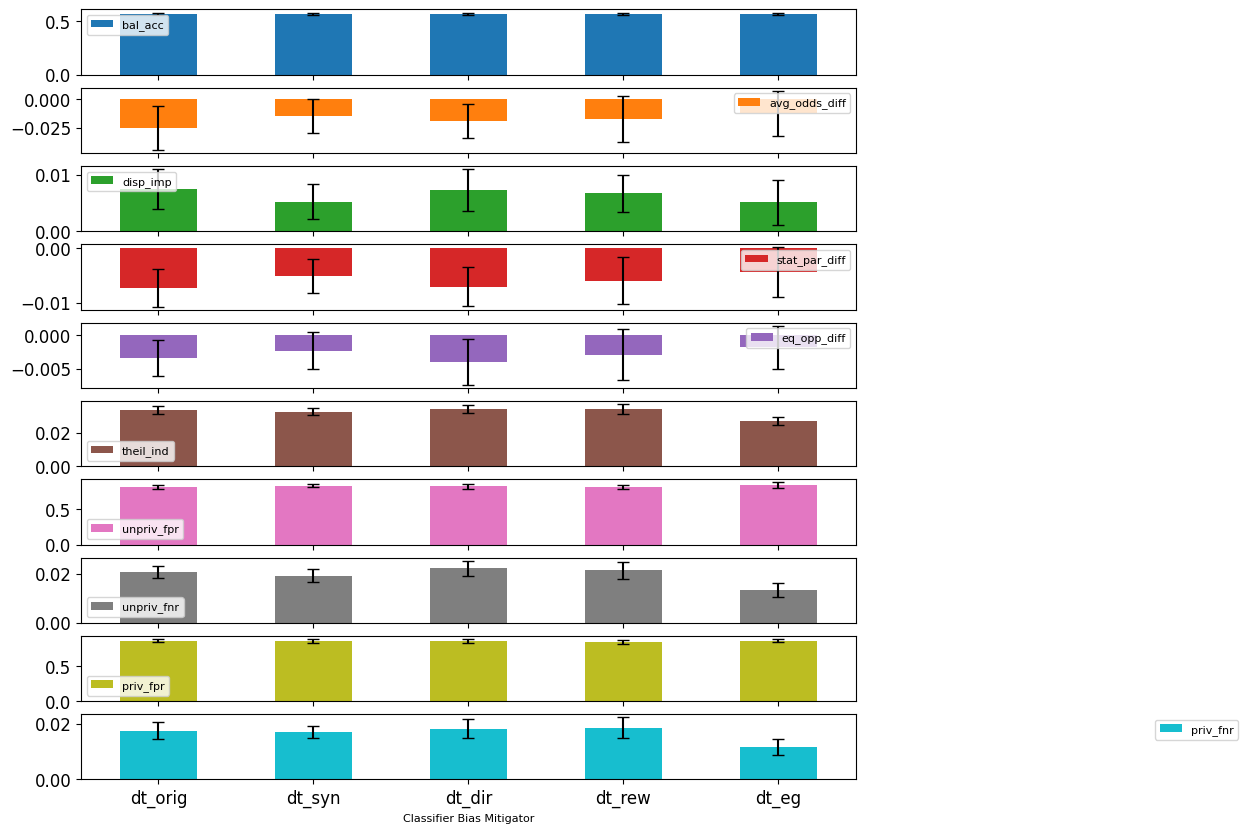

In [87]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        eg_metrics_mean]
#         pr_orig_metrics_mean,
#         cpp_metrics_mean,
#         ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        eg_error_metrics]
#         pr_orig_error_metrics,
#         cpp_error_metrics,
#         ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn'] + [model_type+'_dir'] + [model_type+'_rew'] + [model_type+'_eg'], name='Classifier Bias Mitigator')
#                   + [model_type+'_rew']+  + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [88]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [89]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          eg_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn'] + ['dir'] + ['rew'] + ['eg'], name='Classifier MIA Attacks')
#                   + ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

entire_dataset_mia_privacy_risk  \
Classifier MIA Attacks                                    
orig                                           0.517182   
syn                                            0.516783   
dir                                            0.517528   
rew                                            0.517521   
eg                                             0.506227   

                        entire_dataset_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                              
orig                                                     0.682118   
syn                                                      0.669814   
dir                                                      0.679803   
rew                                                      0.678935   
eg                                                       0.567240   

                        entire_dataset_label_1.0_mia_privacy_risk  \
Classifier MIA Attacks                                              
orig                                                     0.511161   
syn                                                      0.510985   
dir                                                      0.511583   
rew                                                      0.511739   
eg                                                       0.504159   

                        subpopulation_0.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.683908   
syn                                                         0.676153   
dir                                                         0.684568   
rew                                                         0.674702   
eg                                                          0.565269   

                        subpopulation_0.0_label_1.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.513174   
syn                                                         0.512709   
dir                                                         0.513784   
rew                                                         0.513072   
eg                                                          0.504773   

                        subpopulation_1.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.686310   
syn                                                         0.671325   
dir                                                         0.684658   
rew                                                         0.690391   
eg                                                          0.571908   

                        subpopulation_1.0_label_1.0_mia_privacy_risk  
Classifier MIA Attacks                                                
orig                                                        0.511635  
syn                                                         0.511422  
dir                                                         0.512446  
rew                                                         0.512376  
eg                                                          0.503726

In [90]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [91]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [92]:
df_groups

subpopulation_0.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.683908   
syn                                                         0.676153   
dir                                                         0.684568   
rew                                                         0.674702   
eg                                                          0.565269   

                        subpopulation_0.0_label_1.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.513174   
syn                                                         0.512709   
dir                                                         0.513784   
rew                                                         0.513072   
eg                                                          0.504773   

                        subpopulation_1.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.686310   
syn                                                         0.671325   
dir                                                         0.684658   
rew                                                         0.690391   
eg                                                          0.571908   

                        subpopulation_1.0_label_1.0_mia_privacy_risk  
Classifier MIA Attacks                                                
orig                                                        0.511635  
syn                                                         0.511422  
dir                                                         0.512446  
rew                                                         0.512376  
eg                                                          0.503726

<Axes: xlabel='Classifier MIA Attacks'>

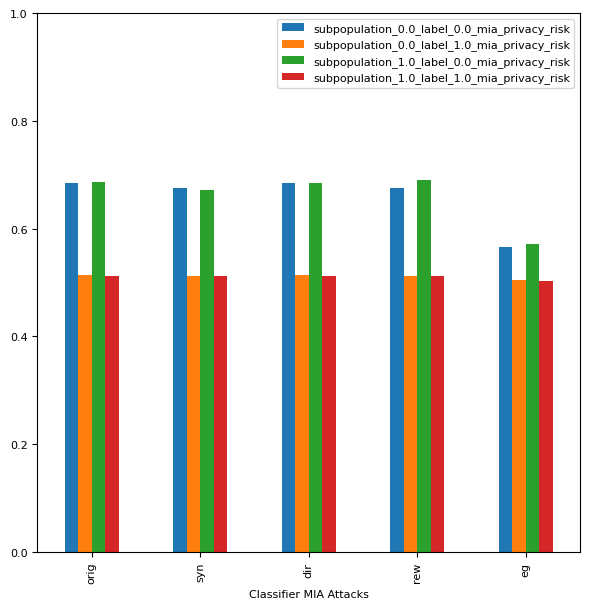

In [93]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [94]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew        eg
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.683908  0.676153  0.684568  0.674702  0.565269
subpopulation_0.0_label_1.0_mia_privacy_risk  0.513174  0.512709  0.513784  0.513072  0.504773
subpopulation_1.0_label_0.0_mia_privacy_risk  0.68631   0.671325  0.684658  0.690391  0.571908
subpopulation_1.0_label_1.0_mia_privacy_risk  0.511635  0.511422  0.512446  0.512376  0.503726


### Visualizing using novel technique

In [95]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [96]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in eg_mia_error_metrics.keys():
    for val in eg_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["eg", key.replace("_mia_attacker_advantage", ""), val])

In [97]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

Fairness                                           MIA  Privacy Risk
0       orig               entire_dataset_mia_privacy_risk      0.517117
1       orig               entire_dataset_mia_privacy_risk      0.517982
2       orig               entire_dataset_mia_privacy_risk      0.517550
3       orig               entire_dataset_mia_privacy_risk      0.521300
4       orig               entire_dataset_mia_privacy_risk      0.524954
..       ...                                           ...           ...
695       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.504434
696       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.505321
697       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.502599
698       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.503012
699       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.501923

[700 rows x 3 columns]

In [98]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

Fairness                                           MIA  Privacy Risk
0       orig               entire_dataset_mia_privacy_risk      0.517117
1       orig               entire_dataset_mia_privacy_risk      0.517982
2       orig               entire_dataset_mia_privacy_risk      0.517550
3       orig               entire_dataset_mia_privacy_risk      0.521300
4       orig               entire_dataset_mia_privacy_risk      0.524954
..       ...                                           ...           ...
695       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.504434
696       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.505321
697       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.502599
698       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.503012
699       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.501923

[500 rows x 3 columns]

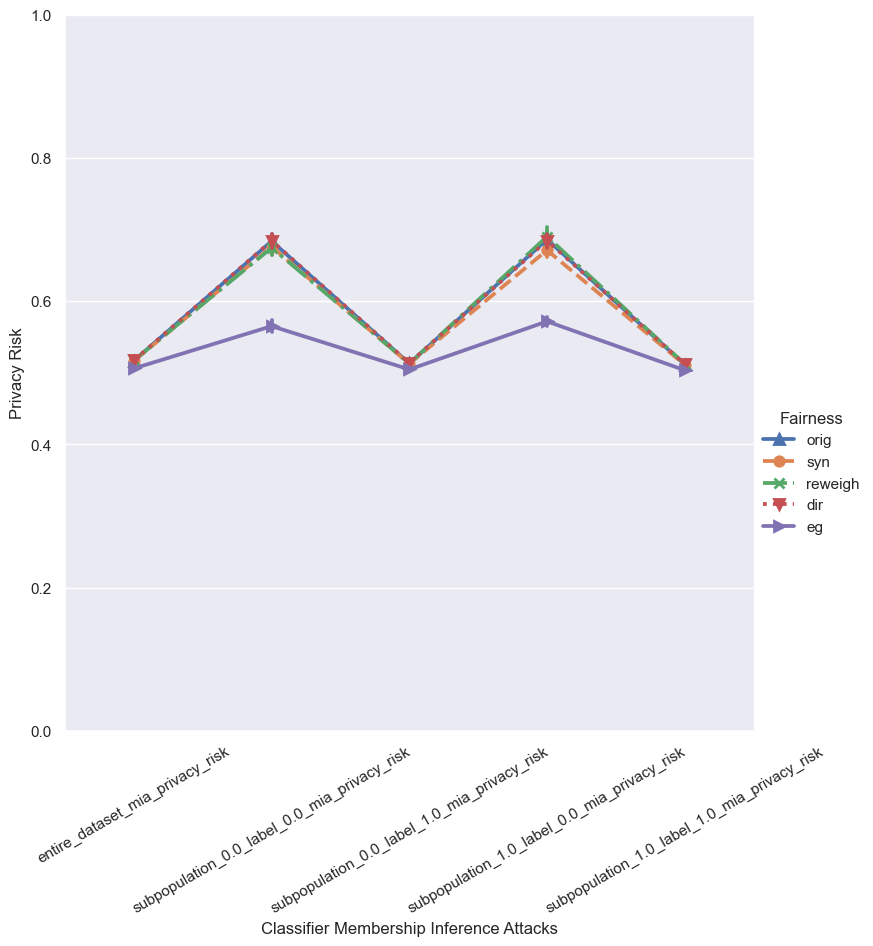

In [99]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [100]:
from sklearn.metrics import RocCurveDisplay, auc

In [101]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

In [ ]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", 
            "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", 
            "subpopulation_1.0_label_0.0_mia_result",
            "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

In [ ]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics], ["orig", "syn"]): 
#                               dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", 
                "subpopulation_0.0_label_0.0_mia_result",
                "subpopulation_0.0_label_1.0_mia_result", 
                "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            print(mia_res)
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        print(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

In [ ]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [ ]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("mia_auc")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("mia_auc")}

In [ ]:
orig_mia_metrics_mean

In [ ]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

In [ ]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [ ]:
# Creating data structures to plot point categorical plot from seaborn

In [ ]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [ ]:
orig_mia_metrics_att_ad

In [ ]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

In [ ]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

In [ ]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


In [ ]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [ ]:
pd.DataFrame(orig_mia_metrics_att_ad)

In [ ]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [ ]:
orig_mia_metrics_mean

In [ ]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

In [ ]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [ ]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("mia_ppv")}

In [ ]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

In [ ]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

In [ ]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [ ]:
import pandas as pd

In [ ]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

In [ ]:
df[["age", "labels"]].value_counts(normalize=True)

In [ ]:
df.drop_duplicates()

## DT Accuracy

In [ ]:
get_orig_model_metrics(dataset_orig_train, dataset_orig_test, unprivileged_groups, f_label, uf_label, BASELINE, SCALER, ATTACK)

In [ ]:
# train_test_egr